# Clase 5

# Teorema de Bayes

Probabilidad condicional: Probabilidad que ocurra un evento dado que otro ocurrió.<img src="img/interseccion_conjuntos.png" alt="Drawing" style="width: 300px;"/>

La probabilidad condicional se denota como: $P(A|B)$ y se lee probabilidad del evento $A$ dado el evento $B$

Teorema de Bayes:
    $$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$

Expresa la probabilidad condicional $P(A|B)$, en términos de la probabilidad de la intersección de los eventos y de las probabilidades de cada evento por separado.

Ejemplo: Se que un test de coronavirus tiene un 90% sensitividad and 95% especificidad y me dio positivo, cual es la probabilidad que tenga coronavirus?
Usando Bayes: $$P(\text{Tengo Corona y me dio positivo}) = \frac{P(\text{Me de positivo y tenga corona})P(\text{Tenga Corona})}{P(\text{Me de positivo})}$$

Calculamos las probabilidades:
    $$P(\text{Me de positivo y tenga corona}) = 0.9\text{ (sensitividad del test)}$$
 

   $$P(\text{Tenga Corona}) = 0.05 (\text{  ej 5% de la población)}$$


$$ P(\text{Me de positivo}) = P(\text{Me de positivo|Tenga corona})*P(\text{Tenga corona}) + P(\text{Me de positivo|No tenga corona})*P(\text{No tenga corona})$$

$$P(\text{Me de positivo}) = 0.9*0.05+0.05*(1-0.05)=0.0925$$

$$P(\text{Tengo Corona|Me dio positivo})=\frac{0.9*0.05}{0.0925} = 0.4864$$


Ejercicio: calcular de los que dieron negativos, cuantos realmente no tenían.

Casos de uso: Estimación de parameter, testeo de hipótesis, cálculo de intervalos de confianza, cualquier tipo de inferencia bayesiana, etc.

## Divergencia de Kullback–Leibler o KL-Divergence

Se define como: $$D_{KL}=\sum_{x \in X} P(x)log( \frac{P(x)}{Q(x)})$$

- Da una noción de similaridad entre distribuciones de probabilidades

- No es una métrica ya que no cumple la desigualdad triangular, por lo tanto siempre conviene calcularla relativa a otra distribución

- Se relaciona con el campo de teoría de información: Dicha cantidad equivale a la información mutua de P respecto Q, es decir, cuanta información de la distribución de probabilidad P hay en la distribución de Q

- El inconveniente de este cálculo es que generalmente no se conocen las distribuciones de probabilidades de las variables y siempre esta la cuestión de: mi histograma se aproxima lo suficiente a mi distribución real?

## [Pymc3: Probabilistic Programming in Python](https://docs.pymc.io/)

- Tiene distribuciones de probabilidades predefinidas 
- Permite hacer cálculos de probabilidades posterior de a priori a partir de datos

## Ejemplo: **Autoregresiones Bayesianas**

Sacado de un [notebook](https://github.com/lambdaclass/finance_playground/blob/master/notebooks/metadata-2019/soy-price-prediction.ipynb) de la competencia metadata 2019 para predecer el precio de la soja.

In [16]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import statsmodels.api as sm

In [7]:
sns.set(rc={'figure.figsize': (12,8)})

In [9]:
date_parser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y 12:00:00 a.m.")
df = pd.read_csv('data/datasetRofex2.csv',
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)

In [10]:
df.head()

,Id,Open,High,Low,Last,Cierre,Aj.Dif.,Mon.,OI.Vol.,OI.Dif.,Vol.Ope.,Unidad,DolarB.N.,DolarItau.,Dif.Sem
Fecha,,,,,,,,,,,,,,,
2004-01-05,1,0.0,0.0,0.0,0.0,221.0,13.0,D,0.0,0.0,0,TONS,2.920,2.905,-221.0
2004-01-06,2,0.0,0.0,0.0,0.0,221.0,0.0,D,0.0,0.0,0,TONS,2.880,2.870,-221.0
2004-01-07,3,0.0,0.0,0.0,0.0,219.0,-2.0,D,0.0,0.0,0,TONS,2.865,2.882,-219.0
2004-01-08,4,0.0,0.0,0.0,0.0,220.0,1.0,D,0.0,0.0,0,TONS,2.887,2.884,-220.0
2004-01-09,5,0.0,0.0,0.0,0.0,220.0,0.0,D,0.0,0.0,0,TONS,2.892,2.900,-220.0


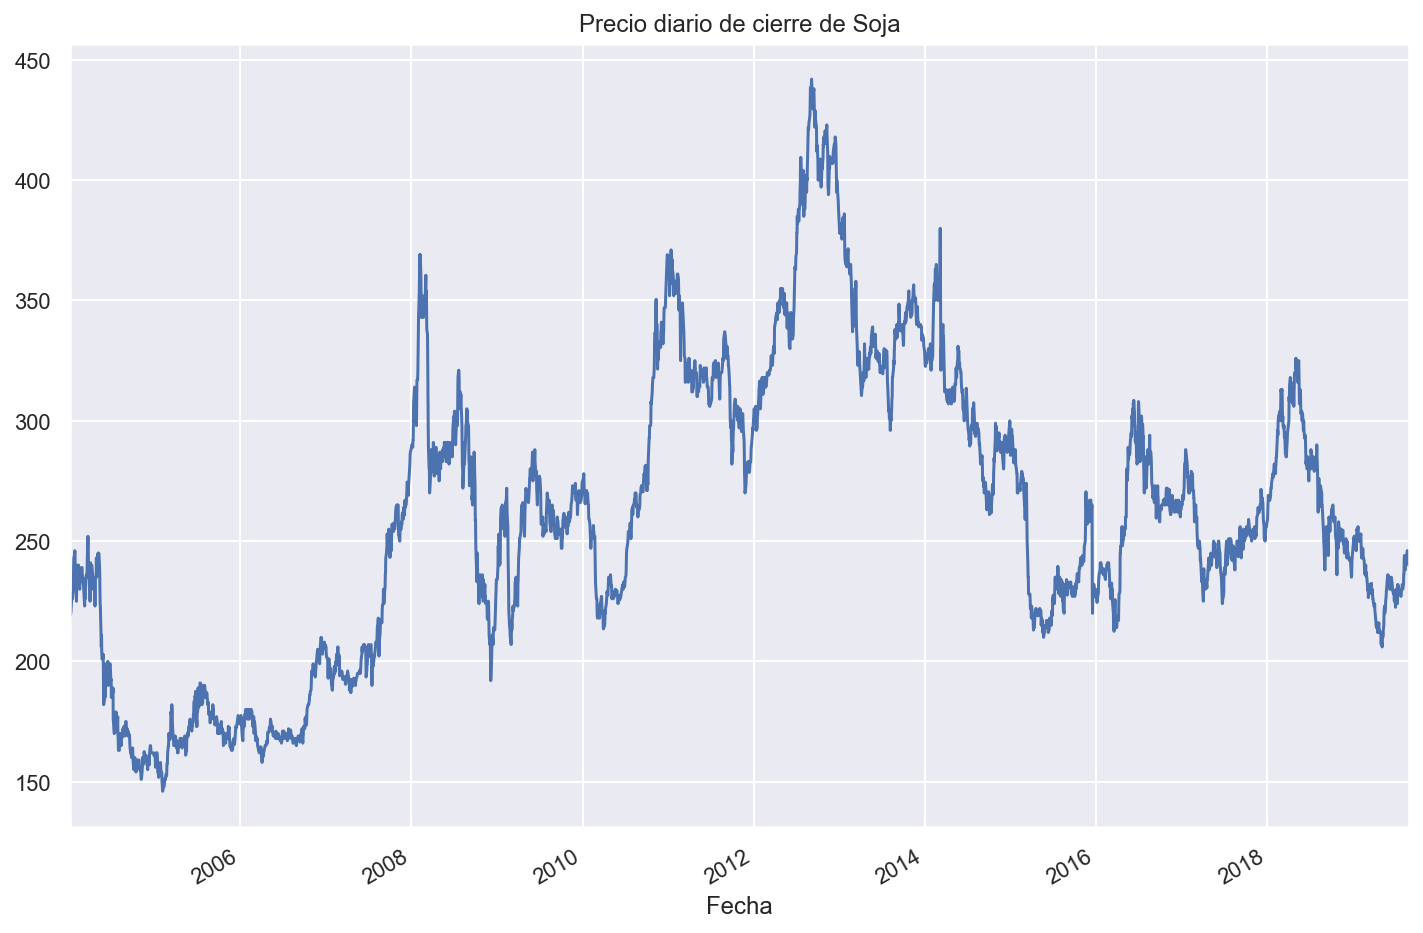

In [12]:
df['Cierre'].plot(title='Precio diario de cierre de Soja');

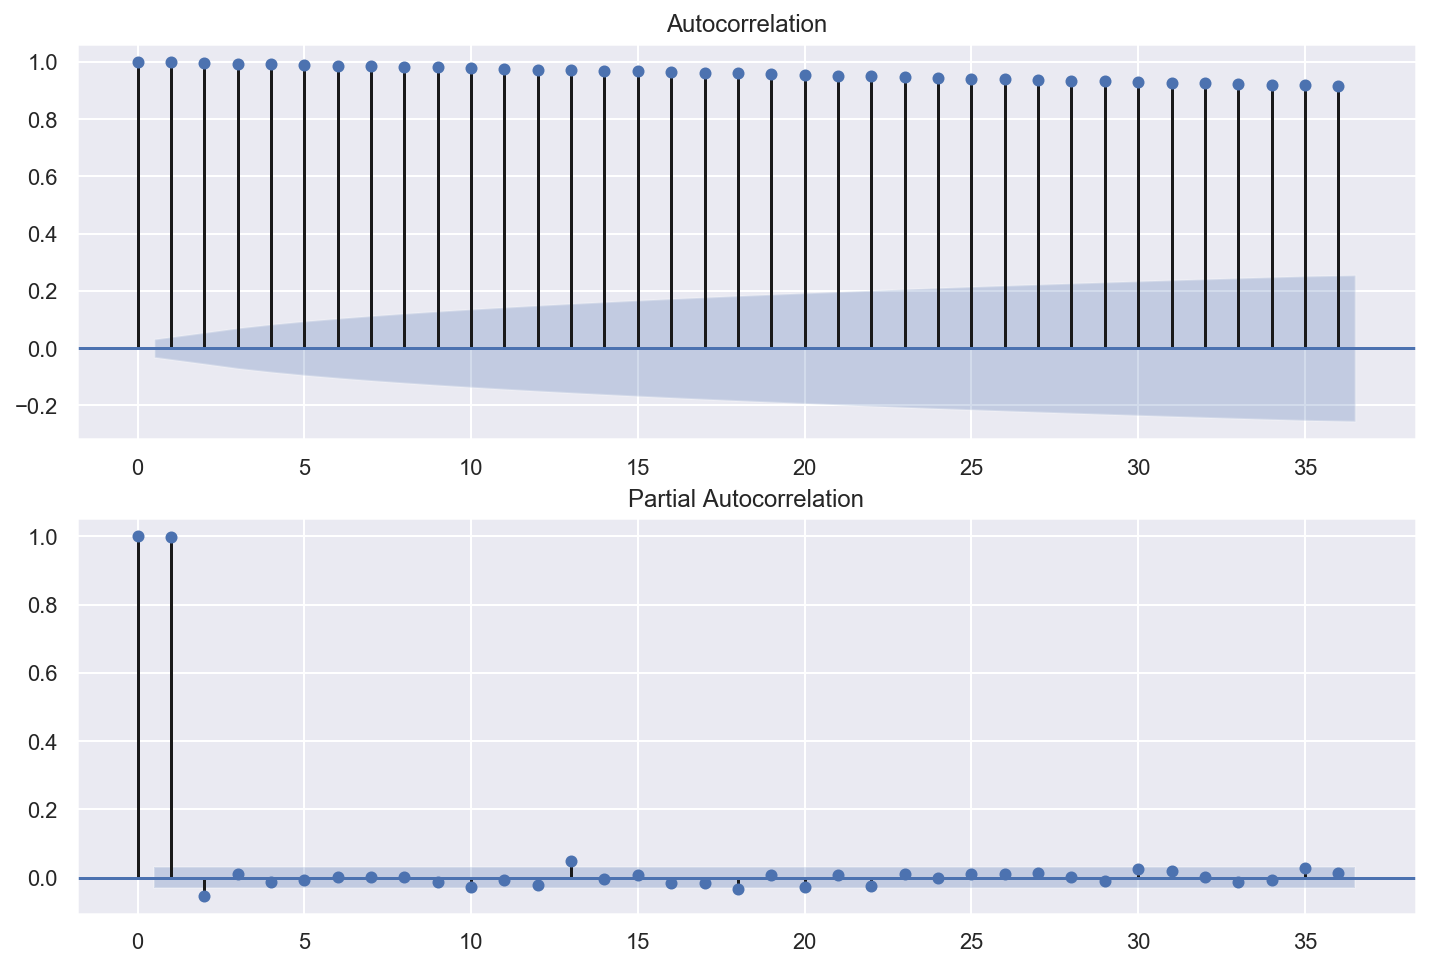

In [17]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(df['Cierre'], ax=ax1)
sm.graphics.tsa.plot_pacf(df['Cierre'], ax=ax2);

#### $AR(1)$ sobre precio de cierre

Probamos modelando la serie de precios como un proceso $AR(1)$:

$$p_t = \phi_1 p_{t-1} + \epsilon_t$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi_1]
Sampling 2 chains: 100%|██████████| 28000/28000 [00:11<00:00, 2487.38draws/s]
/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.3735e+08, ||grad|| = 2.7465e+08: 100%|██████████| 4/4 [00:00<00:00, 86.17it/s]


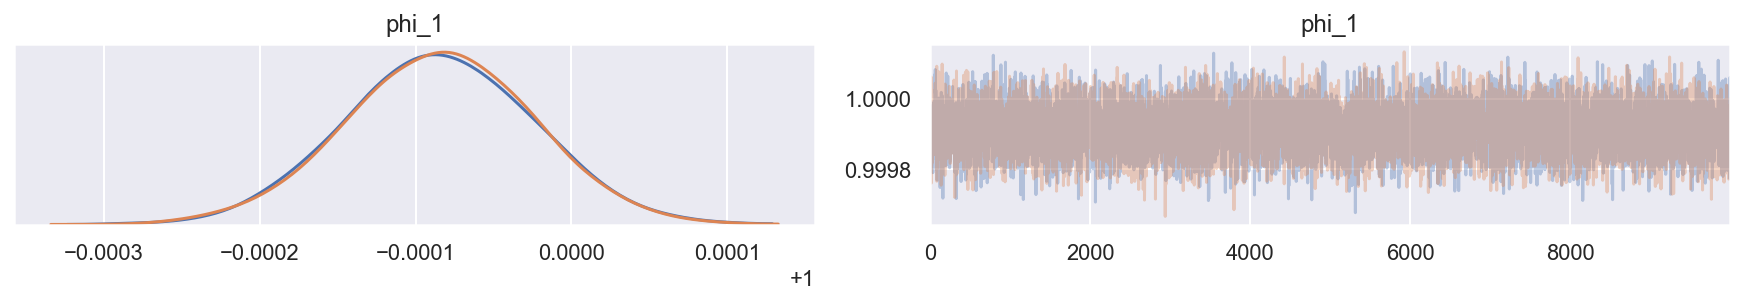

In [14]:
sigma = 1.0

with pm.Model() as ar1:
    phi1 = pm.Normal('phi_1', mu=0, sigma=sigma)
    data = pm.AR('p', phi1, observed=df['Cierre'])
    trace = pm.sample(10000, tune=4000)
    map_ar1 = pm.find_MAP()

pm.traceplot(trace);

Como era esperable según lo visto en los plots de autocorrelación, el modelo asigna un valor cercano a $1$ para el coeficiente del primer término de lag.  
A continuación, hacemos un plot de la predicción del modelo para los próximos 100 días.

In [18]:
phi1_hat = map_ar1['phi_1']

In [19]:
steps = 100

last_day = df.index[-1]
last_price = df.loc[last_day, 'Cierre']
forecast_period = pd.date_range(start=last_day + pd.DateOffset(1), periods=steps, freq='B')

forecast = np.repeat(phi1_hat, steps).cumprod()
forecasts = pd.DataFrame({'forecast': last_price * forecast}, index=forecast_period)
forecast_df = df.append(forecasts, sort=True)

In [20]:
def plot_forecast(forecast_df, steps=100):
    ax = sns.lineplot(x=forecast_df.index[-2*steps:-steps], y=forecast_df['Cierre'][-2*steps:-steps], label='Precio de Cierre')
    sns.lineplot(x=forecast_df.index[-steps:], y=forecast_df['forecast'][-steps:], label='Predicción', ax=ax)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precio')
    ax.figure.autofmt_xdate()
    ax.set_title('Cierre de Soja');

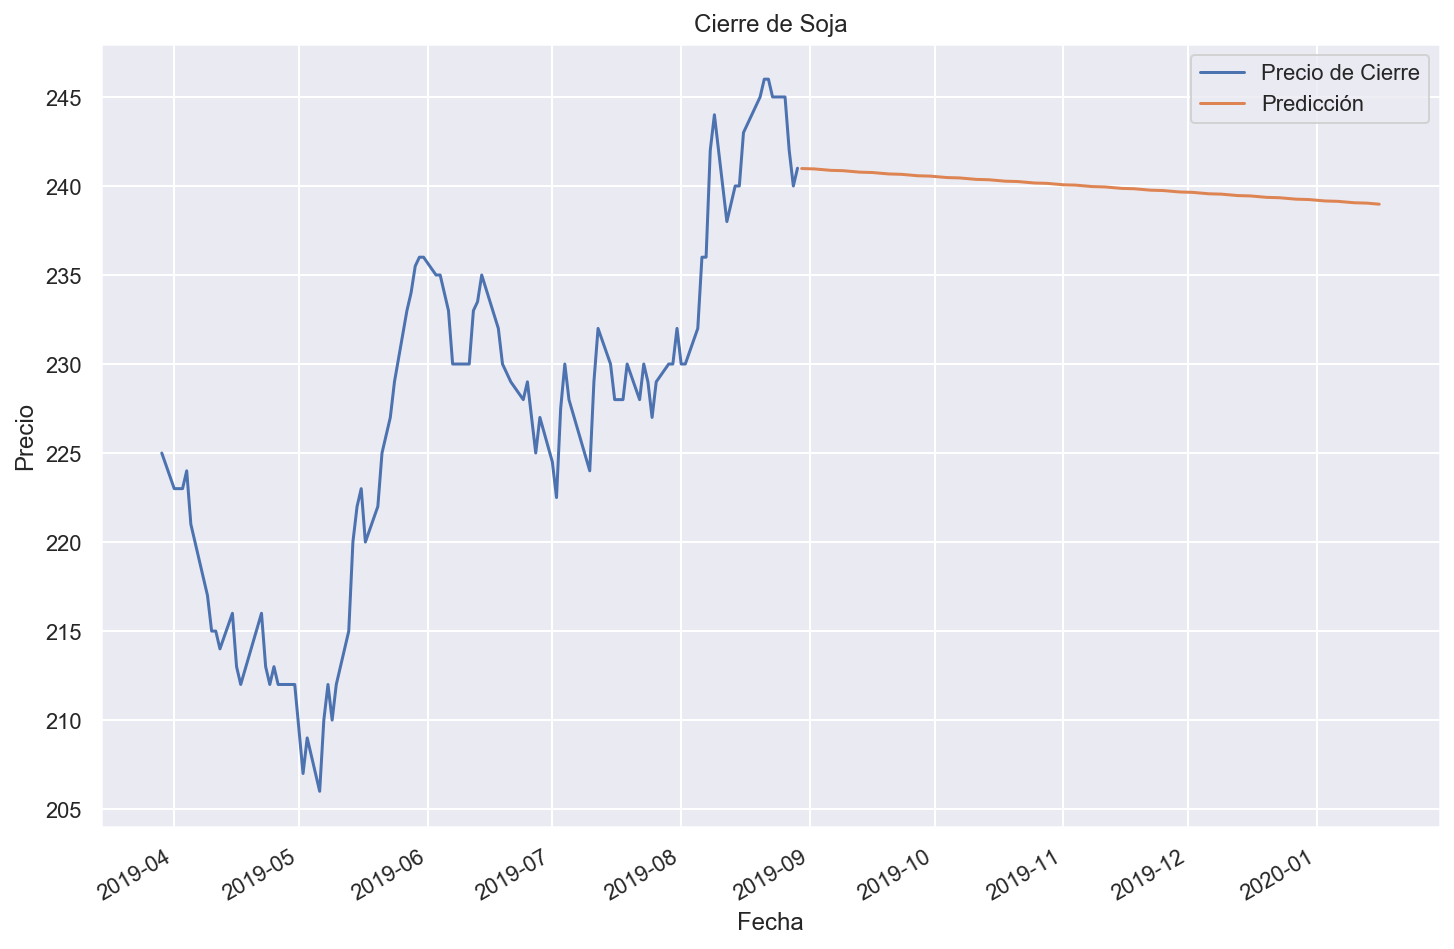

In [21]:
plot_forecast(forecast_df)

#### $AR(2)$ sobre precio de cierre

Probamos ahora un modelo $AR(2)$, sabiendo que la autocorrelación parcial con los lags de mayor orden es cercana a 0.

$$p_t = \phi_1 p_{t-1} + \phi_2 p_{t-2} + \epsilon_t$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi_2, phi_1]
Sampling 2 chains: 100%|██████████| 28000/28000 [03:46<00:00, 123.84draws/s]
The acceptance probability does not match the target. It is 0.91915738470875, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -31,255, ||grad|| = 17.34: 100%|██████████| 13/13 [00:00<00:00, 1646.86it/s]  


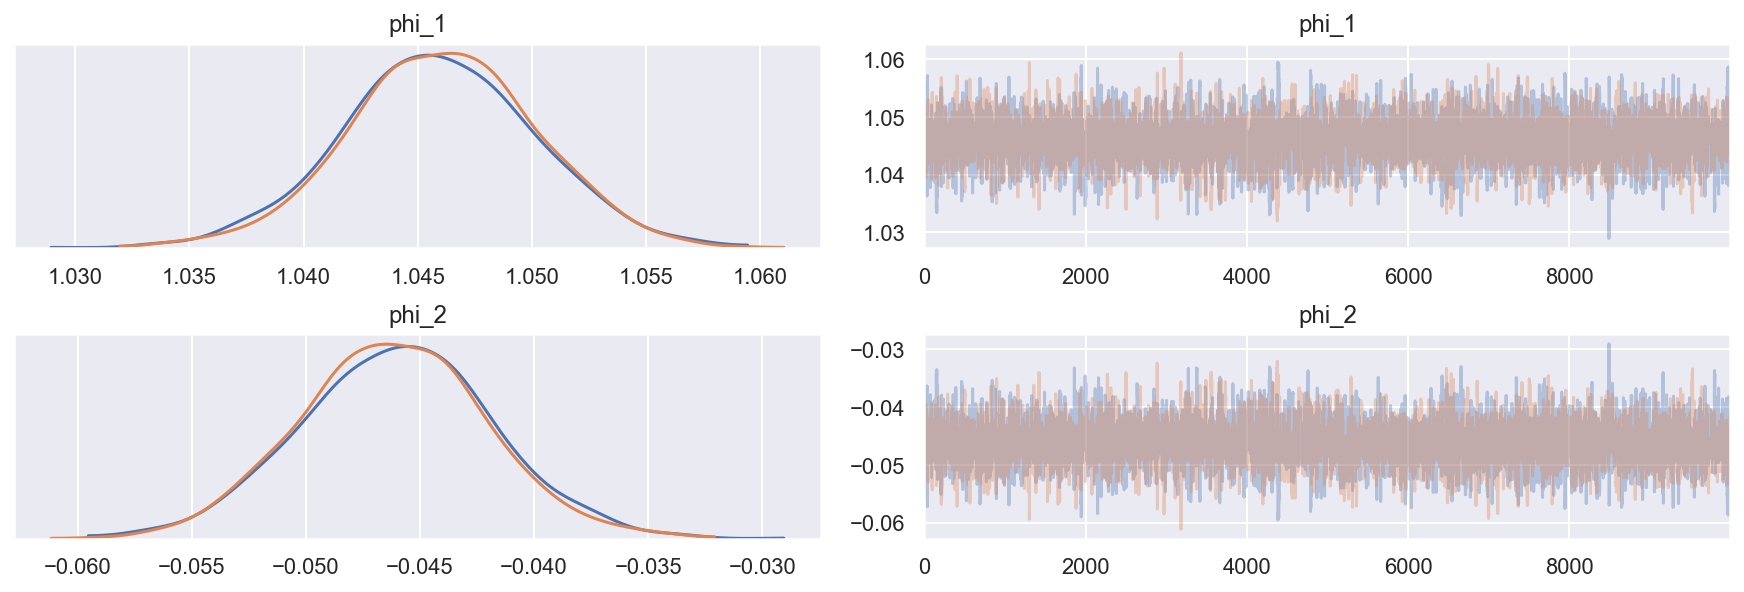

In [23]:
with pm.Model() as ar2:
    phi1 = pm.Normal('phi_1', mu=0, sigma=sigma)
    phi2 = pm.Normal('phi_2', mu=0, sigma=sigma)
    data = pm.AR('p', [phi1, phi2], observed=df['Cierre'])
    trace = pm.sample(10000, tune=4000)
    map_ar2 = pm.find_MAP()

pm.traceplot(trace);

Vemos que el coeficiente del segundo término de lag es cercano a $0$, como era previsible. Veamos el plot de predicciones.

In [26]:
phi1_hat = map_ar2['phi_1']
phi2_hat = map_ar2['phi_2']

In [27]:
def ar2_process(steps, phis, last_prices):
    prices = last_prices.copy()

    for i in range(steps):
        last, second_last, *rest = prices
        next_price = phis[0] * last + phis[1] * second_last
        prices = [next_price] + prices
    
    return np.array(prices[:-2])[::-1]

In [28]:
second_to_last_price = df['Cierre'][-2]
forecast = ar2_process(steps, [phi1_hat, phi2_hat], [last_price, second_to_last_price])
forecasts = pd.DataFrame({'forecast': forecast},
                         index=forecast_period)
forecast_df = df.append(forecasts, sort=True)

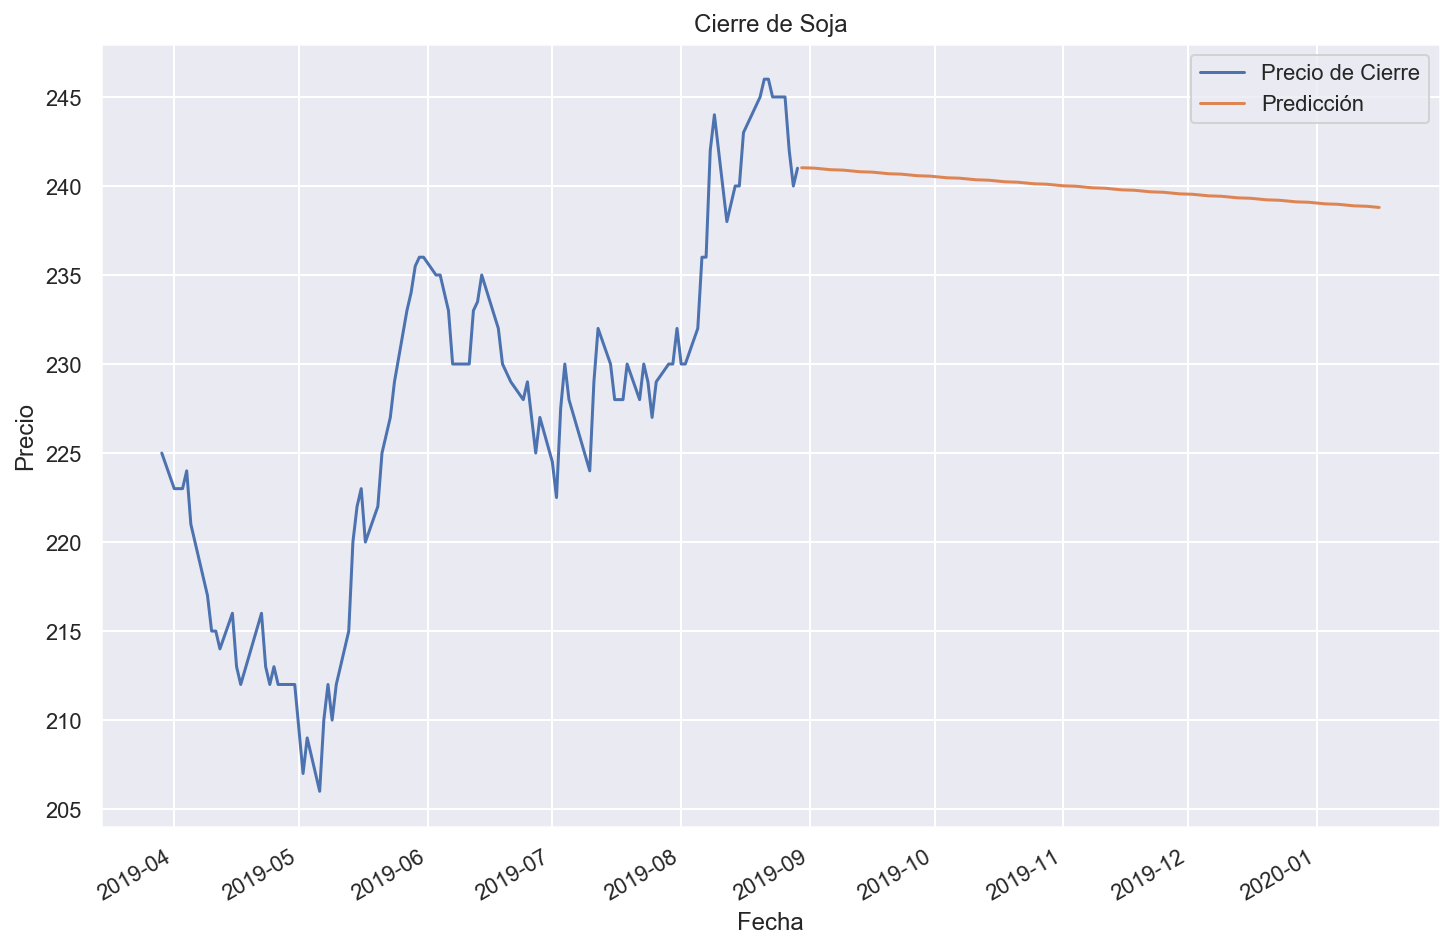

In [29]:
plot_forecast(forecast_df)